# Demo: GPSR Using Bingo

## (1) Import Base Packages ##

In [1]:
import numpy as np;np.seterr(all="ignore")
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import display, clear_output
from tqdm import tqdm

## (2) Import Relevant Bingo Classes ##

In [2]:
#Classes for Genetic Programming (GP)
from bingo.symbolic_regression import ComponentGenerator
from bingo.evolutionary_optimizers.island import Island
from bingo.symbolic_regression.agraph.agraph import AGraph
from bingo.stats.pareto_front import ParetoFront

#Classes for the EVALUATION stage of GPSR
from bingo.symbolic_regression import ExplicitRegression, \
                                      ExplicitTrainingData
from bingo.evaluation.evaluation import Evaluation
from bingo.local_optimizers.continuous_local_opt import ContinuousLocalOptimization

#Classes for the EVOLUTION stage of GPSR
from bingo.symbolic_regression import AGraphGenerator, \
                                      AGraphCrossover, \
                                      AGraphMutation

#Classes for the SELECTION stage of GPSR
from bingo.evolutionary_algorithms.generalized_crowding import \
                                      GeneralizedCrowdingEA
from bingo.selection.deterministic_crowding import DeterministicCrowding

## (2) Initialize GPSR Hyperparameters ##
Note: Hyperparameters relating to the criterion check and information storage not present in this code. Refer to BingoExample/example_code/main_script.py for additional information.

In [3]:
POPULATION_SIZE = 104
STACK_SIZE = 24
MAX_GENERATIONS = 100

## (3) Make Training Data ##

<IPython.core.display.Javascript object>


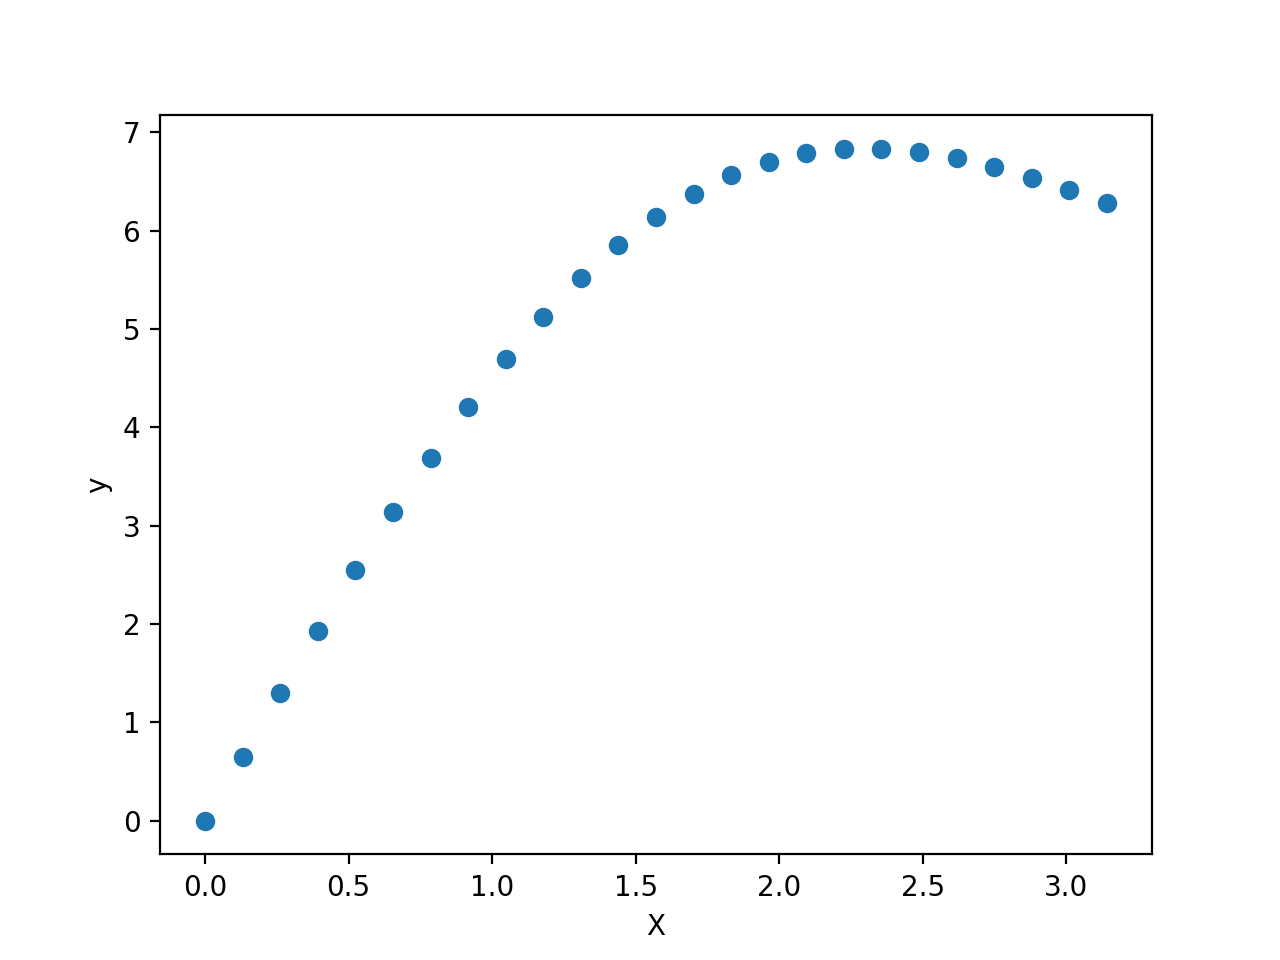

Text(0, 0.5, 'y')

In [4]:
model = AGraph(equation="3*sin(X_0) + 2*X_0")
X = np.linspace(0, np.pi, 25).reshape((-1,1))
y = model.evaluate_equation_at(X)
training_data = ExplicitTrainingData(x=X, y=y)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")

## (4) Initialize component generator, mutation and crossover objects, and AGraph generators ##

In [15]:
component_generator = ComponentGenerator(training_data.x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")
component_generator.add_operator("sin")
component_generator.add_operator("cos")

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)
agraph_generator = AGraphGenerator(STACK_SIZE, component_generator,
                                       use_simplification=True)

## (5) Initialize fitness metric, parameter optimizer, and evaluator ##

In [16]:
fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
evaluator = Evaluation(local_opt_fitness)

## (6) Initialize selection and evolutionary algorithm ##

In [17]:
selection_phase = DeterministicCrowding()
ea = GeneralizedCrowdingEA(evaluator, crossover,
                      mutation, 0.4, 0.4, selection_phase)

## (7) Initialize Bingo Island with Hall of Fame ##

In [18]:
def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 
def make_island():
    """
    Function created for repeated runs.
    """
    island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
    return island

## (8) Run GPSR and Visualize Results ##

In [19]:
# Simple Visualization Code

def plot_best_n_individuals(ax, island, n=10):
    ax.clear()
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    idxs = np.argsort(fits)[:n]
    for i in idxs:
        ind = island.population[i]
        ax.plot(X, ind.evaluate_equation_at(X)) 
    ax.scatter(X, y, color="k", label="Training Data")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_ylim(0, 10)
    
def update_ax(ax, fig, x, y_mu, y_upper, y_lower):
    ax.clear()
    ax.set_ylim(0, 2.5)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Mean Fitness")
    ax.plot(x, y_mu, color="b")
    ax.fill_between(x, y_upper, y_lower, color="b", alpha=0.3)
    

<IPython.core.display.Javascript object>


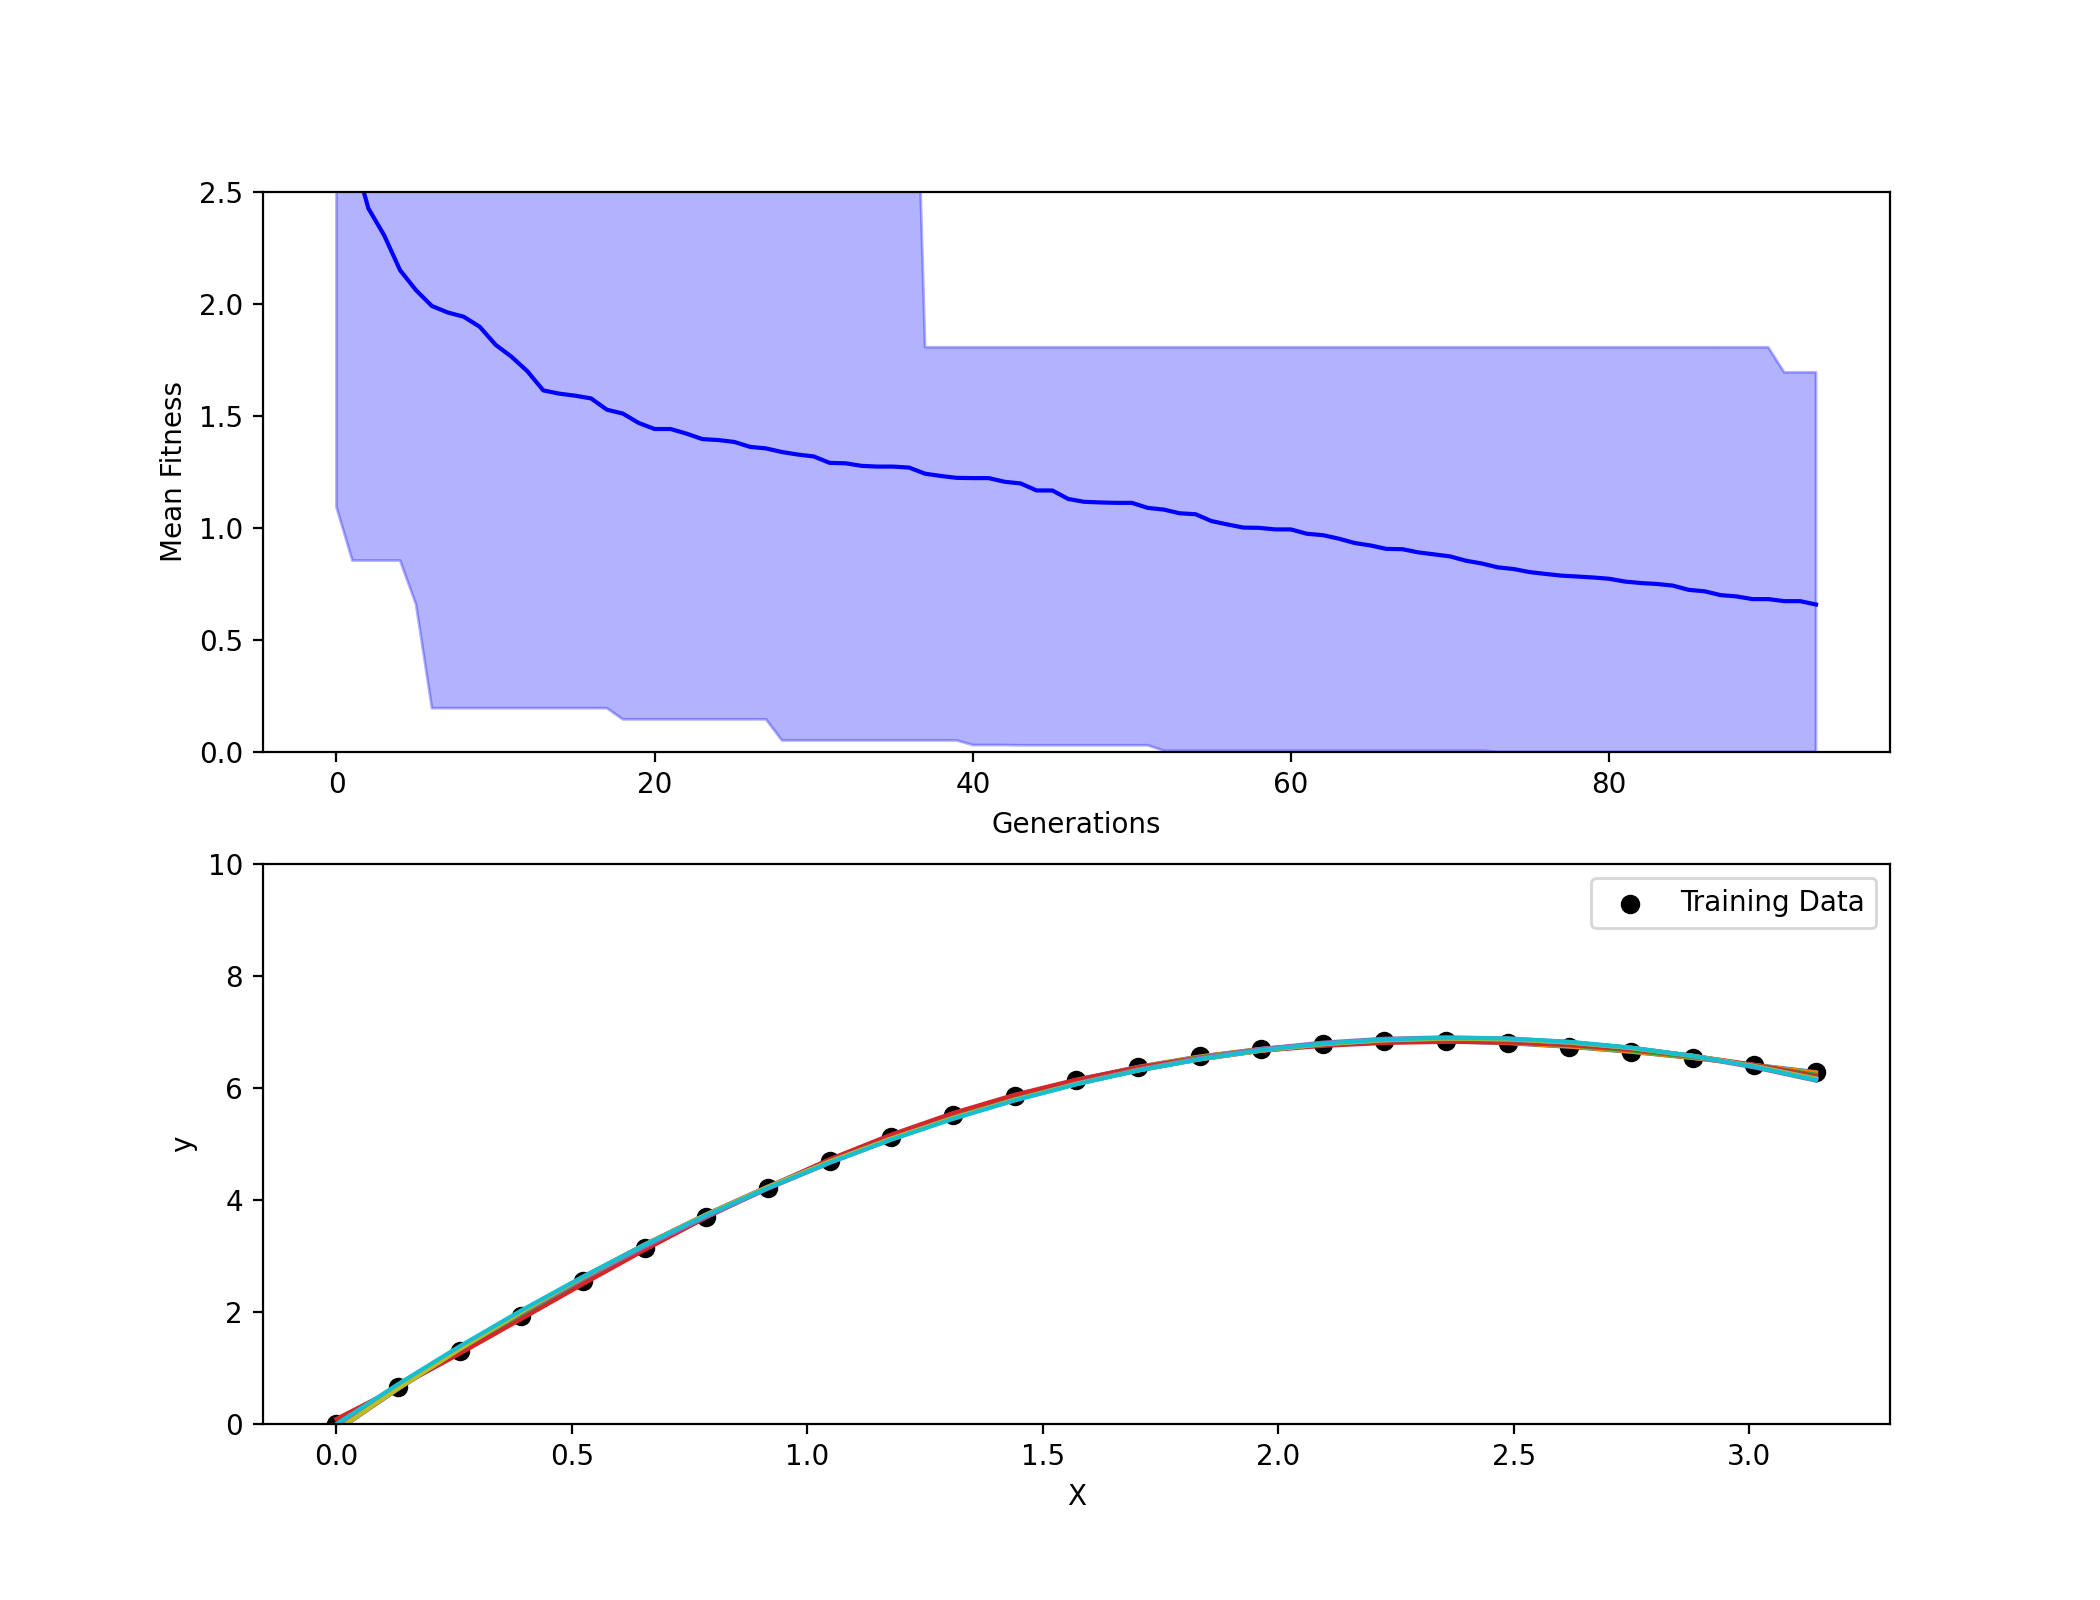

Text(0, 0.5, 'y')

In [20]:
fig, axs = plt.subplots(2, figsize=(10.5, 8))
axs[0].set_ylim(0, 1)
axs[1].scatter(X, y, color="k", label="Training Data")
axs[1].legend()
axs[0].set_ylim(0, 2.5)
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Mean Fitness")
axs[1].set_ylim(0, 10)
axs[1].set_xlabel("X")
axs[1].set_ylabel("y")

In [ ]:
island = make_island()
#fig, axs = plt.subplots(2, figsize=(10.5, 8))
plt.show()
axs[0].set_xlabel("X")
axs[0].set_ylabel("y")

print("Best individual at initialization\n f(X_0) =", island.get_best_individual())
best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)
fits = [ind.fitness for ind in island.population]
means = [np.nanmean(fits)]
maxs = [np.nanmax(fits)]
mins = [np.nanmin(fits)]
fig.canvas.draw()

for i in tqdm(range(MAX_GENERATIONS)):
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
        print(f"Best individual at generation {island.generational_age}\n f(X_0) =", island.get_best_individual())
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    means += [np.nanmean(fits)]
    maxs += [np.nanmax(fits)]
    mins += [np.nanmin(fits)]
    update_ax(axs[0], fig, np.arange(island.generational_age+1), np.array(means), np.array(maxs), np.array(mins))
    plot_best_n_individuals(axs[1], island, n=10)
    fig.canvas.draw()


Best individual at initialization
 f(X_0) = 3.401642529386761 + X_0


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Best individual at generation 1
 f(X_0) = 1.8308462025918657 + (1.9999999999999998)(X_0)


  5%|██▏                                        | 5/100 [00:01<00:20,  4.72it/s]

Best individual at generation 5
 f(X_0) = 4.9724388561816575 + X_0 + (-2)(cos(X_0)) + (-2)((cos(X_0))(cos(X_0)))
Best individual at generation 6
 f(X_0) = ((-1)(0.6648703847176564))(X_0) + (1.988258536009173 + X_0)((0.6648703847176564)(X_0) - (cos(1.988258536009173 + X_0)))


 18%|███████▌                                  | 18/100 [00:03<00:15,  5.42it/s]

Best individual at generation 18
 f(X_0) = (-0.02802632384734419 + cos(0.8305800652660865 + X_0))(-3.175627979690568 - (cos(-0.02802632384734419 + cos(0.8305800652660865 + X_0)))) - (-3.175627979690568)


 28%|███████████▊                              | 28/100 [00:05<00:13,  5.46it/s]

Best individual at generation 28
 f(X_0) = -0.11648665928861544 - ((X_0)(-5.88083319279595 + (1.235307571897156)(X_0)))


 31%|█████████████                             | 31/100 [00:05<00:12,  5.42it/s]

Best individual at generation 31
 f(X_0) = -0.11648665928861396 - ((X_0)(-5.880833192795951 + (1.235307571897156)(X_0)))


 40%|████████████████▊                         | 40/100 [00:07<00:11,  5.39it/s]

Best individual at generation 40
 f(X_0) = (1.6077329628167407 + cos(-2.372743727378806 + X_0))(5.867003963908023 - (cos((1.0777191866261497)(-2.372743727378806 + X_0)))) - (5.867003963908023)


 43%|██████████████████                        | 43/100 [00:08<00:11,  5.09it/s]

Best individual at generation 43
 f(X_0) = -33.40118522250047 + (cos(-8.52615162457441))((9.18311736142464 + X_0)(-4.983565276395441 - (cos((cos(-8.52615162457441))(9.18311736142464 + X_0)))))


 52%|█████████████████████▊                    | 52/100 [00:09<00:09,  4.99it/s]

Best individual at generation 52
 f(X_0) = -11.469453043187967 + (cos(0.5844867300875218))((2.9609111598315256 + X_0)(3.854509614688826 - (cos((cos(0.5844867300875218))(2.9609111598315256 + X_0)))))


 73%|██████████████████████████████▋           | 73/100 [00:14<00:05,  4.92it/s]

Best individual at generation 73
 f(X_0) = (2.9999999999999987)(X_0) + (3.000000000000002)(sin((0.9999999999999996)(X_0))) - (X_0)


 74%|███████████████████████████████           | 74/100 [00:14<00:05,  4.85it/s]

Best individual at generation 74
 f(X_0) = (3.0)(X_0) + (2.9999999999999996)(sin((1.0)(X_0))) - (X_0)


 93%|███████████████████████████████████████   | 93/100 [00:18<00:01,  5.01it/s]

## Print Hall of Fame ###

In [14]:
for ind in island.hall_of_fame:
    print(f"model (fitness={ind.fitness}), fitness: {str(ind)}, {ind.fitness}")

model (fitness=0.030550328693165648), fitness: (X_0)(0.40183539272856234 + ((-1)(-1.1074128020770413))(4.563538428513027 - (X_0)) + sin((-1.1074128020770413)(4.563538428513027 - (X_0))) - (cos(X_0))), 0.030550328693165648
model (fitness=0.03964054097301914), fitness: 3.5997584607429642 + sin((1.7277022292769848)(X_0)) + (4.09446944631562)(cos(-21.43121709845172 + X_0)), 0.03964054097301914
model (fitness=0.04937586923374554), fitness: -33.538553093398804 + (-40.43443700952587)(cos((48.25125723233513)(-5746.340198555289 + X_0))), 0.04937586923374554
model (fitness=0.051638189660022815), fitness: -0.11648665928861565 + (1.2353075718971562)((X_0)(4.760622638914377 - (X_0))), 0.051638189660022815
model (fitness=0.10699398936675816), fitness: (7.008865693642704)(sin((0.676175314579878)(X_0))), 0.10699398936675816
model (fitness=0.5201572188277539), fitness: (X_0)(4.972438856181658 - (X_0)), 0.5201572188277539
model (fitness=1.0340820492707707), fitness: 3.8803511163020197 + X_0, 1.034082049